In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yaml 
import os 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [23]:
# Simulation Date
sysname = "VehiGAN"
version = 'december_esorics'
version = 'october_24_wisec_8'
version = 'today'
version = 'january_icdcs'
gen_size = 1000
data_dir = Path(f'../artifacts/results_{version}/')
data_dir

PosixPath('../artifacts/results_january_icdcs')

In [24]:
cfg = yaml.safe_load(open('../config/config.yaml'))
attack_index_dict = {attack : indx for indx, attack in enumerate(cfg['selected_attacks'])}
if not os.path.exists("../artifacts/plots/"): 
	os.makedirs("../artifacts/plots/") 

# Analyze Adversarial Attacks

In [25]:
# Get ADS for all the discriminator
advFnc = 'pgd'
per_files = glob.glob(f'../artifacts/results_{version}/advAttacks/adv_performance_*.csv')
print(per_files)
performance_df = pd.DataFrame([])
for per_file_name in per_files:
    if advFnc not in per_file_name:
        continue
    performance_df = pd.concat([performance_df, pd.read_csv(per_file_name, index_col=0)], axis=0)
performance_df = performance_df.drop(columns=['support'])
performance_df = performance_df.replace(advFnc, advFnc.upper())
performance_df
# performance_df = performance_df.replace("fgsm", 'FGSM')

['../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fn_pgd_indv_0.01.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fp_pgd_trans_0.02.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fp_pgd_multi_0.01.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fn_pgd_indv_0.02.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fn_pgd_indv_0.0.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fp_pgd_indv_0.01.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fp_pgd_trans_0.015.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fn_pgd_indv_0.005.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fn_pgd_indv_0.015.csv', '../artifacts/results_january_icdcs/advAttacks/adv_performance_drop_10_fp_pgd_indv_0.005.csv', '../artifacts/results_january_icdcs/advAttacks/adv_pe

,precision,recall,fscore,TPR,FPR,TNR,FNR,advFunc,Model,Epsilon,advType,advCap,modAcc,modCount
0,1.000000,0.727273,0.842105,0.727273,0.000000,0.272727,0.272727,No Attack,wgan_10_4_64_75_1000,0.01,fn,indv,White-box,0
1,1.000000,0.727273,0.842105,0.727273,0.000000,0.272727,0.272727,Random Noise,wgan_10_4_64_75_1000,0.01,fn,indv,White-box,0
2,1.000000,0.636364,0.777778,0.636364,0.000000,0.363636,0.363636,PGD,wgan_10_4_64_75_1000,0.01,fn,indv,White-box,0
3,1.000000,0.636364,0.777778,0.636364,0.000000,0.363636,0.363636,No Attack,wgan_10_4_64_50_1000,0.01,fn,indv,White-box,1
4,1.000000,0.636364,0.777778,0.636364,0.000000,0.363636,0.363636,Random Noise,wgan_10_4_64_50_1000,0.01,fn,indv,White-box,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,1.000000,0.362500,0.532110,0.362500,0.000000,0.637500,0.637500,Random Noise,wgan_10_3_8_25_1000,0.01,fp,trans,Black-box,8
26,1.000000,0.362500,0.532110,0.362500,0.000000,0.637500,0.637500,PGD,wgan_10_3_8_25_1000,0.01,fp,trans,Black-box,8
27,1.000000,0.393750,0.565022,0.393750,0.000000,0.606250,0.606250,No Attack,wgan_10_5_64_75_1000,0.01,fp,trans,Black-box,9
28,1.000000,0.393750,0.565022,0.393750,0.000000,0.606250,0.606250,Random Noise,wgan_10_5_64_75_1000,0.01,fp,trans,Black-box,9


In [26]:
# Apply filters in a loop
def filter_df(original_data, filter_rules = None):
    filtered_data = original_data.copy()
    if filter_rules== None:
        return filtered_data
    for column, values in filter_rules.items():
        values = [values] if not isinstance(values, list) else values
        filtered_data = filtered_data[filtered_data[column].isin(values)]
    return filtered_data

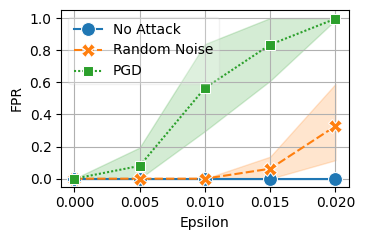

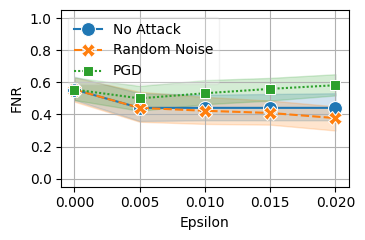

In [41]:
attack_dict = {
    'fp': 'FPR',
    'fn' : 'FNR'}

for advType, metric in attack_dict.items():
    filter_rules = {
        'advType' : advType,
        'advCap': 'indv'
    }
    data = filter_df(performance_df, filter_rules)
    plt.figure(figsize=(3.75,2.5))
    if data.shape[0] > 0:
        sns.lineplot(data, x = 'Epsilon', y = metric, hue = 'advFunc',style = 'advFunc', markers=True, markersize = '10')
        # sns.boxenplot(data, x = 'Epsilon', y = metric, hue = 'advFunc',)
    # plt.legend(title='Attack Type', loc = 'upper left', framealpha=0.5, bbox_to_anchor = (0,1.2))
    plt.legend( loc = 'upper left', framealpha=0.25, bbox_to_anchor = (0,1.0))
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig(f"../artifacts/plots/single_WGAN_{metric}.jpg", dpi = 350)
    plt.savefig(f"../artifacts/plots/single_WGAN_{metric}.pdf", dpi = 350)
    plt.show()

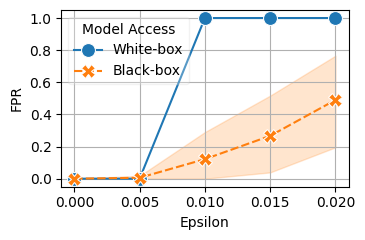

In [42]:
attack_dict = {
    'fp': 'FPR'}

for advType, metric in attack_dict.items():
    filter_rules = {
        'advType' : advType,
        'advCap': 'trans',
        'advFunc': advFnc.upper()
    }
    data = filter_df(performance_df, filter_rules)
    plt.figure(figsize=(3.75,2.5))
    if data.shape[0] > 0:
        sns.lineplot(data, x = 'Epsilon', y = metric, hue = 'modAcc',style = 'modAcc', markers=True, markersize='10')
    plt.legend(title='Model Access', loc = 'upper left', framealpha=0.25)
    plt.grid(True)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig(f"../artifacts/plots/trans_WGAN_{metric}.jpg", dpi = 350)
    plt.savefig(f"../artifacts/plots/trans_WGAN_{metric}.pdf", dpi = 350)
    plt.show()

## Visualize adversarial attacks

In [148]:
# Get ADS for all the discriminator
per_files = glob.glob(f'../artifacts/FGSM_samples/*.txt')
print(per_files)
adv_Data = {}
file_id_list = []
for indx, per_file_name in enumerate(per_files):
    file_id = Path(per_file_name).name.split("_")[0]
    file_id_list.append(file_id)
    data_type = Path(per_file_name).name.split("_")[-1].split(".")[0]
    adv_Data[f"{data_type}_{file_id}"]= np.loadtxt(per_file_name)
file_id_list = list(set(file_id_list))
adv_Data
# performance_df = performance_df.drop(columns=['support'])
# performance_df = performance_df.replace("fgsm", 'FGSM')
# performance_df


# epsilons = [0.01]
# adv_Data = {}
# for eps in epsilons:
#     file_dir = f'../artifacts/results_{version}/advAttacks/adv_X_data_10_fp_fgsm_indv_{eps}_wgan_10_4_64_75_1000_White-box_250.npy'
#     X_test = np.load(file_dir)
#     adv_Data[eps] = X_test

['../artifacts/FGSM_samples/9fc1ab4d-b07f-4535-8cad-590c8ee967f6_gradient.txt', '../artifacts/FGSM_samples/b3cc03c3-f3c8-46be-a054-e7b20d0f7c3a_perturbation.txt', '../artifacts/FGSM_samples/13b53a46-c77b-4038-a348-920bb68b5937_gradient.txt', '../artifacts/FGSM_samples/6aadaf29-dabc-4ae8-91c6-5fef4c73683b_advimage.txt', '../artifacts/FGSM_samples/49c2fd80-f959-414a-8ec4-71be096df040_orgimage.txt', '../artifacts/FGSM_samples/b3cc03c3-f3c8-46be-a054-e7b20d0f7c3a_orgimage.txt', '../artifacts/FGSM_samples/9fc1ab4d-b07f-4535-8cad-590c8ee967f6_advimage.txt', '../artifacts/FGSM_samples/9f8d44ef-edb5-464c-aef2-a484cf39188f_advimage.txt', '../artifacts/FGSM_samples/86648701-cda8-422e-80c8-65f2af8a680a_advimage.txt', '../artifacts/FGSM_samples/ffd32d15-6477-4484-9039-ade7fa222490_perturbation.txt', '../artifacts/FGSM_samples/9fc1ab4d-b07f-4535-8cad-590c8ee967f6_orgimage.txt', '../artifacts/FGSM_samples/35fbed5a-211a-4813-9e75-0f531c90f92f_advimage.txt', '../artifacts/FGSM_samples/6aadaf29-dabc-4a

{'gradient_9fc1ab4d-b07f-4535-8cad-590c8ee967f6': array([[ 2.81954166e-02, -9.37115550e-02,  1.35101182e-02,
         -1.98293682e-02, -3.64411157e-03, -1.54781146e-02,
         -4.32002172e-03, -1.12030879e-02, -1.05854459e-02,
         -1.43591489e-03, -2.41085943e-02,  1.80076808e-01],
        [ 3.97656113e-02, -1.58171922e-01,  1.59026217e-02,
         -2.34100409e-02, -5.34897577e-03, -1.55541962e-02,
          3.05772503e-03, -7.17349304e-03, -1.21183340e-02,
          4.52341139e-03, -5.03848307e-02,  3.74823362e-02],
        [-4.02066857e-02,  1.53260380e-01,  8.85922089e-03,
         -3.37735526e-02,  3.52633023e-03, -7.34640937e-03,
         -5.85260335e-03, -1.31561328e-03, -2.45304443e-02,
         -3.14624272e-02, -2.61816550e-02,  1.44010767e-01],
        [-5.56740239e-02,  2.43550941e-01,  2.37551946e-02,
         -3.10550779e-02,  3.57620092e-03, -1.19371954e-02,
         -5.38971927e-03,  3.80082289e-04, -1.78861003e-02,
         -3.13374810e-02, -6.29636869e-02,  3.01

In [149]:
print(adv_Data.keys())

dict_keys(['gradient_9fc1ab4d-b07f-4535-8cad-590c8ee967f6', 'perturbation_b3cc03c3-f3c8-46be-a054-e7b20d0f7c3a', 'gradient_13b53a46-c77b-4038-a348-920bb68b5937', 'advimage_6aadaf29-dabc-4ae8-91c6-5fef4c73683b', 'orgimage_49c2fd80-f959-414a-8ec4-71be096df040', 'orgimage_b3cc03c3-f3c8-46be-a054-e7b20d0f7c3a', 'advimage_9fc1ab4d-b07f-4535-8cad-590c8ee967f6', 'advimage_9f8d44ef-edb5-464c-aef2-a484cf39188f', 'advimage_86648701-cda8-422e-80c8-65f2af8a680a', 'perturbation_ffd32d15-6477-4484-9039-ade7fa222490', 'orgimage_9fc1ab4d-b07f-4535-8cad-590c8ee967f6', 'advimage_35fbed5a-211a-4813-9e75-0f531c90f92f', 'perturbation_6aadaf29-dabc-4ae8-91c6-5fef4c73683b', 'gradient_9043dba0-f304-4c53-90e6-cd08e14fb555', 'orgimage_353c080e-9405-48de-b7b1-b266751d7918', 'advimage_9043dba0-f304-4c53-90e6-cd08e14fb555', 'perturbation_8deafff1-2453-47a1-880c-c62e5c1ef71c', 'advimage_87732e56-2cea-4377-99c3-cb4875892d0a', 'gradient_86648701-cda8-422e-80c8-65f2af8a680a', 'perturbation_353c080e-9405-48de-b7b1-b266

In [150]:
cfg = yaml.safe_load(open('../config/config.yaml'))
from types import SimpleNamespace
cfg = SimpleNamespace(**cfg)

In [151]:
features = [
    '$v_x$',
    '$\Delta x$',
    '$v_y$',
    '$\Delta y$',
    '$a_x$',
    '$\Delta v_x$',
    '$a_y$',
    '$\Delta a_y$',
    '$\Delta \\theta_x$',
    '$\omega_x$',
    '$\Delta \\theta_y$',
    '$\omega_y$']


In [152]:
features_sorted = [
    '$\Delta x$',
    '$\Delta y$',
    '$v_x$',
    '$v_y$',
    '$\Delta v_x$',
    '$\Delta a_y$',
    '$a_x$',
    '$a_y$',
    '$\Delta \\theta_x$',
    '$\Delta \\theta_y$',
    '$\omega_x$',
    '$\omega_y$']

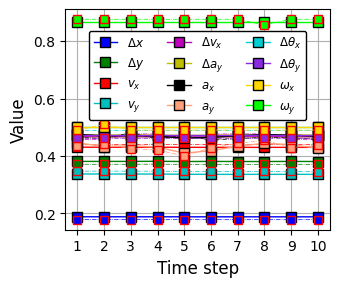

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming indx, adv_Data, file_id_list, and cfg are defined
indx = 3
# Extract dataframes
df_ben = pd.DataFrame(adv_Data[f"orgimage_{file_id_list[indx]}"], columns=features, index=range(1,11))
df_adv = pd.DataFrame(adv_Data[f"advimage_{file_id_list[indx]}"], columns=features, index=range(1,11))
df_grad = pd.DataFrame(adv_Data[f"gradient_{file_id_list[indx]}"], columns=features, index=range(1,11))
df_pert = pd.DataFrame(adv_Data[f"perturbation_{file_id_list[indx]}"], columns=features, index=range(1,11))

# Generate a palette with ten distinct colors
colors = sns.color_palette('tab10', n_colors=len(cfg.features))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA07A', '#00CED1', '#8A2BE2', '#FFD700', '#00FF00']

# Plot each feature with a unique color
plt.figure(figsize=(3.5,3))
for i, feature in enumerate(features_sorted):
    plt.plot(df_ben[feature], linestyle='-', linewidth=1, marker='s', markersize = 7.5, color=colors[i], markeredgecolor='black', label=feature)
    plt.plot(df_adv[feature], linestyle='-.', linewidth=0.5, marker='s', markersize = 6, color=colors[i], markeredgecolor='red')

# Add labels and legend with a black border
legend = plt.legend(loc = 'center', bbox_to_anchor=(0.5, 0.7), ncols=3, framealpha=1.0, fontsize = 8.5)
legend.get_frame().set_linewidth(1)  # Set legend border width
legend.get_frame().set_edgecolor('black')  # Set legend border color
plt.xticks(range(1,11))
plt.xlabel("Time step", fontsize= 12)
plt.ylabel("Value", fontsize= 12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../artifacts/plots/adv_FP_attack.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/adv_FP_attack.pdf", dpi = 350)
plt.show()


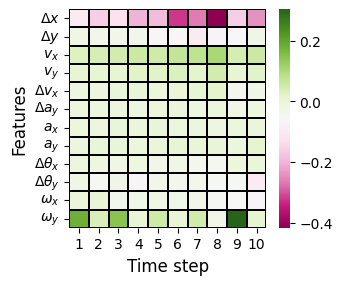

In [214]:
plt.figure(figsize=(3.5,3))
sns.heatmap(df_grad[features_sorted].T, cmap="PiYG", linewidths=0.1, linecolor='k')
plt.ylabel("Features", fontsize= 12)
plt.xlabel("Time step", fontsize= 12)
plt.tight_layout()
plt.savefig(f"../artifacts/plots/adv_FP_grad.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/adv_FP_grad.pdf", dpi = 350)
plt.show()


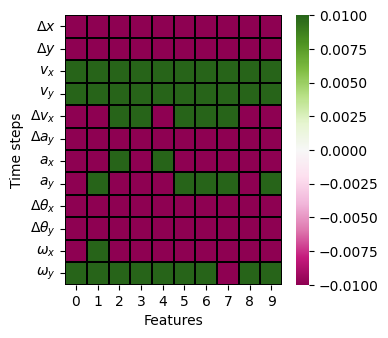

In [183]:
plt.figure(figsize=(3.5,3.5))
sns.heatmap(df_pert[features_sorted].T, cmap="PiYG", linewidths=0.1, linecolor='k')
plt.xlabel("Features")
plt.ylabel("Time steps")
plt.show()

In [181]:
df_grad

,$v_x$,$\Delta x$,$v_y$,$\Delta y$,$a_x$,$\Delta v_x$,$a_y$,$\Delta a_y$,$\Delta \theta_x$,$\omega_x$,$\Delta \theta_y$,$\omega_y$
0,0.028257,-0.094353,0.010567,-0.020982,-0.003360,-0.012894,-0.006362,-0.010713,-0.010585,-0.001436,-0.024109,0.180077
1,0.040806,-0.158684,0.012512,-0.029338,-0.008885,-0.011371,0.001447,-0.009202,-0.012118,0.004523,-0.050385,0.037482
2,0.046575,-0.125459,0.007177,-0.033169,0.000280,0.001490,-0.000036,-0.011158,-0.022664,-0.031923,-0.026182,0.144011
3,0.058034,-0.203701,0.021129,-0.033764,-0.001820,0.001109,-0.003293,-0.016707,-0.013240,-0.032415,-0.062964,0.003016
4,0.051945,-0.190892,0.021998,-0.062342,0.000107,-0.005636,-0.000613,-0.005259,-0.028907,-0.022264,-0.030061,0.054935
5,0.071884,-0.323961,0.031348,-0.062758,-0.003979,0.004938,0.008904,-0.001371,-0.020353,-0.032216,-0.034807,0.003394
6,0.077080,-0.267720,0.019267,-0.097578,-0.007384,0.008760,0.004886,-0.014264,-0.038265,-0.031015,-0.036955,0.047727
7,0.105211,-0.417130,0.045657,-0.069693,-0.014203,0.017707,0.003802,-0.007982,-0.043375,-0.048325,-0.049126,-0.030529
8,0.042268,-0.158581,0.012885,-0.057429,-0.006911,-0.037835,-0.007526,-0.026063,-0.003479,-0.054491,-0.047640,0.303882
9,0.058701,-0.241167,0.020095,-0.027007,-0.001994,-0.024762,0.016064,-0.012772,-0.001907,-0.069699,-0.093791,0.014839


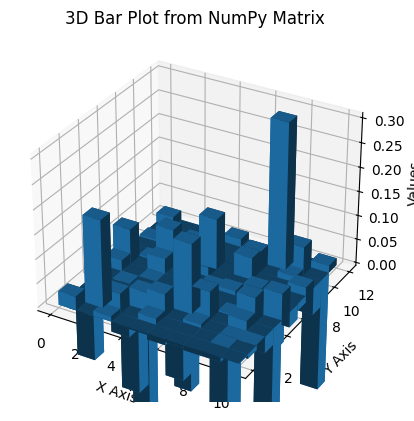

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example 2D NumPy matrix
matrix =df_grad.values

# Create 3D bar plot with matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get matrix shape
x_size, y_size = matrix.shape
x_positions, y_positions = np.meshgrid(np.arange(x_size), np.arange(y_size))

# Flatten matrices and convert to 1D arrays
x_positions = x_positions.flatten()
y_positions = y_positions.flatten()
z_values = matrix.flatten()

# Create 3D bars
ax.bar3d(x_positions, y_positions, np.zeros_like(z_values), 1, 1, z_values,)

# Add labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Values')
ax.set_title('3D Bar Plot from NumPy Matrix')

# Show the plot
plt.show()

In [ ]:
df_ben.plot(figsize=(10,3))
df_adv.plot(figsize=(10,3))

In [ ]:
df_adv.plot()

In [ ]:
(df_ben - df_adv).plot()


In [ ]:
plt.imshow(adv_Data[0.02][0])

In [ ]:
per_files

In [ ]:
# filter_rules = {
#     'advFunc': 'fgsm'
# }
# data = filter_df(performance_df, filter_rules)
# if data.shape[0] > 0:
#     sns.set_style("ticks",{'axes.grid' : True})
#     ax = sns.catplot(data, col= 'advType', x = 'Epsilon', y = 'FPR', kind='point', dodge=True, height=3, aspect=1.25)


# filter_rules = {
#     'advFunc': 'fgsm'
# }
# data = filter_df(performance_df, filter_rules)
# if data.shape[0] > 0:
#     sns.set_style("ticks",{'axes.grid' : True})
#     ax = sns.catplot(data, col= 'advType', x = 'Epsilon', y = 'FPR', hue = 'modAcc', kind='point', dodge=True, height=3, aspect=1.25)


# Visualize Robust Ensemble Performance

## Benign Performance

In [ ]:
# Get ADS for all the discriminator
per_files = glob.glob(f'../artifacts/results_{version}/ens_detector_*_mean_10_benign_indv_0.01.csv')
print(per_files)
performance_dict = {}
for per_file_name in per_files:
    metric, mean, window, eval_type = Path(per_file_name.replace('.csv', '')).name.split("_")[2:-2]
    performance_dict[f"{metric}_{mean}_{window}_{eval_type}"] = pd.read_csv(per_file_name, index_col=0)


In [ ]:
for i, (key, value) in enumerate(performance_dict.items()):
    plt.figure(figsize=(5.25,3))
    # Set the colormap to go from green to red
    custom_cmap = sns.color_palette("RdYlGn", as_cmap=True)
    # if i == len(performance_dict)-1:
    #    cbar = True
    # else:
    # annot_kws={'fontsize': 12, 'fontstyle': 'italic', 'color':'b', 'alpha': 0.6,
    #                    'rotation': 'vertical', 'verticalalignment': 'center', 'backgroundcolor': 'w'}
    annot_kws={'color':'k', 'verticalalignment': 'center'}
    
    cbar = True #vmin = 0.80, vmax = 0.90,
    ax = sns.heatmap(value, annot=True, fmt = ".2f", annot_kws=annot_kws,  cmap=custom_cmap, linewidths=0.5, alpha=0.5, linecolor='gray', square=False, cbar=cbar)
    for _, spine in ax.spines.items():
      spine.set_visible(True)
    # plt.title(key)
    plt.tick_params(axis='x', labeltop=True, labelbottom=False)
    plt.xlabel("Number of candidate models, $m$")
    plt.ylabel("Number of deployed models, $k$")
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    file_dir = f'../artifacts/plots/robust_detector_{key}.jpg'
    file_dir = f'../artifacts/plots/robust_detector_{key}.pdf'
    plt.savefig(file_dir)
    plt.show()

## Adversarial Performance

In [ ]:
# Get ADS for all the discriminator
per_files = glob.glob(f'../artifacts/results_{version}/advAttacks/ens_detector_fpr_mean_*.csv')
print(per_files)
performance_dict = {}
for per_file_name in per_files:
    window, advType, eps = Path(per_file_name.replace('.csv', '')).name.split("_")[-3:]
    performance_dict[f"Setting: {window}, {advType}, {eps}"] = pd.read_csv(per_file_name, index_col=0)

In [ ]:
# for i, (key, value) in enumerate(performance_dict.items()):
#     plt.figure(figsize=(5.25,3))
#     # Set the colormap to go from green to red
#     custom_cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
#     # if i == len(performance_dict)-1:
#     #    cbar = True
#     # else:
#     cbar = True
#     annot_kws={'color':'k', 'verticalalignment': 'center'}
  
#     ax = sns.heatmap(value, annot=True, fmt = ".2f", vmin=0, vmax=1, annot_kws=annot_kws, cmap=custom_cmap, linewidths=0.5, alpha=0.5, linecolor='gray', square=False, cbar=cbar)
#     for _, spine in ax.spines.items():
#       spine.set_visible(True)
#     # plt.title(key) 
#     plt.tick_params(axis='x', labeltop=True, labelbottom=False)
#     plt.xlabel("Number of candidate models, $m$")
#     plt.ylabel("Number of deployed models, $k$")
#     ax.xaxis.tick_top() # x axis on top
#     ax.xaxis.set_label_position('top')
#     plt.tight_layout()
#     file_dir = f'../artifacts/plots/robust_detector_{key}.jpg'
#     file_dir = f'../artifacts/plots/robust_detector_{key}.pdf'
#     plt.savefig(file_dir)
#     plt.show()

In [ ]:
for i, (key, value) in enumerate(performance_dict.items()):
    print(key)
    # plt.figure(figsize=(5.25,3))
    # Set the colormap to go from green to red
    custom_cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
    # if i == len(performance_dict)-1:
    #    cbar = True
    # else:
    cbar = True
    fig, axes = plt.subplots(1,2, figsize=(5.5,2.5), sharex=True, sharey = True)

    ax = axes[0]
    sns.boxplot(value, color='green', boxprops=dict(alpha=.50), ax = ax)
    sns.lineplot(value.mean(axis=0), marker = 'p', color = 'k', markersize = '8', ax = ax)
    ax.set_xlabel("# of candidate models, $m$")
    ax.set_ylabel("FPR")
    ax.grid(True)
    ax = axes[1]
    sns.lineplot(value.T.iloc[:,:6], linestyle='-', markers=True, markersize= '8', ax = ax)
    ax.set_xlabel("# of candidate models, $m$")
    ax.set_ylabel("FPR")
    ax.legend(title='# of deployed models, $k$', ncols = 2, framealpha = 0.50)
    ax.grid(True)

    plt.tight_layout()
    file_dir = f'../artifacts/plots/robust_detector_{key}_new.jpg'
    file_dir = f'../artifacts/plots/robust_detector_{key}_new.pdf'
    plt.savefig(file_dir)
    plt.show()


## Scalability Test

In [41]:
# load scalability data
import pandas as pd
df_scale_1 = pd.read_csv("../artifacts/plots/data_analysis/scalability_inference_comp_False.csv", index_col=0)
# df_scale_2 = pd.read_csv("../artifacts/plots/data_analysis/scalability_inference_comp_True.csv", index_col=0)
# df_scale = pd.concat([df_scale_1, df_scale_2], axis = 0)
df_scale = pd.concat([df_scale_1], axis = 0)
df_scale

,Model Type,Inference Time,Model
0,Standard (CPU),288.184404,wgan_3_8_25_1000
0,TFLite (CPU),0.719309,wgan_3_8_25_1000
0,Standard (CPU),273.736954,wgan_3_8_50_1000
0,TFLite (CPU),0.350833,wgan_3_8_50_1000
0,Standard (CPU),279.925466,wgan_3_8_75_1000
...,...,...,...
0,TFLite (CPU),0.558376,wgan_5_64_50_1000
0,Standard (CPU),342.248559,wgan_5_64_75_1000
0,TFLite (CPU),0.468373,wgan_5_64_75_1000
0,Standard (CPU),336.022973,wgan_5_64_100_1000


In [97]:
import seaborn as sns
from matplotlib import pylab as plt
# sns.barplot(df_scale, y = 'Inference Time', x="Model",)
# sns.swarmplot(df_scale, y = 'Inference Time', x="Model", hue="Model", alpha = 0.75)
# # sns.violinplot(df_scale, y = 'Inference Time', x="Model Type",)
# plt.legend([])

In [50]:
df_scale

,Model Type,Inference Time,Model
0,Standard (CPU),288.184404,wgan_3_8_25_1000
0,TFLite (CPU),0.719309,wgan_3_8_25_1000
0,Standard (CPU),273.736954,wgan_3_8_50_1000
0,TFLite (CPU),0.350833,wgan_3_8_50_1000
0,Standard (CPU),279.925466,wgan_3_8_75_1000
...,...,...,...
0,TFLite (CPU),0.558376,wgan_5_64_50_1000
0,Standard (CPU),342.248559,wgan_5_64_75_1000
0,TFLite (CPU),0.468373,wgan_5_64_75_1000
0,Standard (CPU),336.022973,wgan_5_64_100_1000


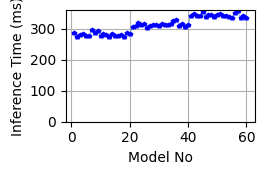

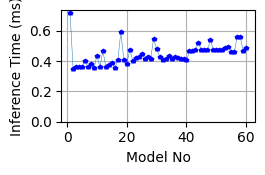

In [101]:
import seaborn as sns
from matplotlib import pylab as plt
data = df_scale[df_scale['Model Type'] == 'Standard (CPU)']
import numpy as np
data = data.reset_index()
data['Model No'] = data.index + 1
plt.figure(figsize=(2.75,1.85))
# sns.scatterplot(data, y = 'Inference Time', x="Model No",)
sns.lineplot(data, y = 'Inference Time', x="Model No", marker = 'p',
             linewidth = '0.35', markersize = '4',
             markerfacecolor='blue', markeredgecolor='none')
plt.grid(True)
plt.ylim(0)
plt.ylabel("Inference Time (ms)")
# plt.legend([])
# plt.xticks(range(1, 60, 10))
plt.tight_layout()
file_dir = f'../artifacts/plots/scalability_std.jpg'
file_dir = f'../artifacts/plots/scalability_std.pdf'
plt.savefig(file_dir)
plt.show()

import seaborn as sns
from matplotlib import pylab as plt
data = df_scale[df_scale['Model Type'] == 'TFLite (CPU)']
import numpy as np
data = data.reset_index()
data['Model No'] = data.index + 1
plt.figure(figsize=(2.75,1.85))
# sns.scatterplot(data, y = 'Inference Time', x="Model No",)
sns.lineplot(data, y = 'Inference Time', x="Model No", marker = 'p',
             linewidth = '0.35', markersize = '4',
             markerfacecolor='blue', markeredgecolor='none')
plt.grid(True)
plt.ylim(0)
plt.ylabel("Inference Time (ms)")
plt.savefig("{}")
plt.tight_layout()
file_dir = f'../artifacts/plots/scalability_lite.jpg'
file_dir = f'../artifacts/plots/scalability_lite.pdf'
plt.savefig(file_dir)
plt.show()

,index,Model Type,Inference Time,Model,Model No
0,0,Standard (CPU),288.184404,wgan_3_8_25_1000,2
1,0,Standard (CPU),273.736954,wgan_3_8_50_1000,3
2,0,Standard (CPU),279.925466,wgan_3_8_75_1000,4
3,0,Standard (CPU),281.921029,wgan_3_8_100_1000,5
4,0,Standard (CPU),276.103377,wgan_3_16_25_1000,6
5,0,Standard (CPU),277.258992,wgan_3_16_50_1000,7
6,0,Standard (CPU),295.830011,wgan_3_16_75_1000,8
7,0,Standard (CPU),286.818027,wgan_3_16_100_1000,9
8,0,Standard (CPU),294.262886,wgan_3_32_25_1000,10
9,0,Standard (CPU),276.508451,wgan_3_32_50_1000,11


In [ ]:
import seaborn as sns
from matplotlib import pylab as plt
sns.barplot(df_scale, y = 'Inference Time', x="Model Type",)
sns.swarmplot(df_scale, y = 'Inference Time', x="Model", hue="Model", alpha = 0.75)
# sns.violinplot(df_scale, y = 'Inference Time', x="Model Type",)
plt.legend([])

# Analyze Different Windows

In [ ]:
# Get ADS for all the discriminator
per_files = glob.glob(f'../artifacts/results_{version}/performance_gen_dis*.csv')
print(per_files)
performance_df = pd.DataFrame([])
for per_file_name in per_files:
    performance_df = pd.concat([performance_df, pd.read_csv(per_file_name, index_col=0)], axis=0)
performance_df

In [ ]:
for model_id in performance_df.index:
    _, window, no_of_layers, latent_dim, epochs, _ = model_id.split("_")
    performance_df.loc[model_id, "window"] = int(window)
    performance_df.loc[model_id, 'no_of_layers'] = int(no_of_layers)
    performance_df.loc[model_id, 'latent_dim'] = int(latent_dim)
    performance_df.loc[model_id, 'epochs'] = int(epochs)

In [ ]:
performance_df = performance_df.sort_values(["AUROC"],ascending=False)
performance_df.head(10)

In [ ]:
for hue in ['no_of_layers', 'latent_dim', 'epochs']:
    plt.figure()
    sns.boxenplot(performance_df, x = hue, y = "AUROC", hue =hue, palette = 'Blues', alpha = 0.50) # x = "window"
    plt.show()


In [ ]:
sns.boxenplot(performance_df, x = "window", y = "AUROC", hue = "latent_dim", palette = 'Blues', alpha = 0.50)


In [ ]:
sns.boxenplot(performance_df, x = "window", y = "AUROC", hue = "latent_dim", palette = 'Blues', alpha = 0.50)


In [ ]:
sns.boxenplot(performance_df[performance_df["window"] == 10], x = "epochs", y = "AUROC", hue = 'no_of_layers',  palette = 'Blues', alpha = 0.50)

# Gather all Data for WGAN

In [ ]:
window = 10

### Get GS for all the generators


In [ ]:
gen_files = glob.glob(f'../artifacts/results_{version}/gen*.json')

gen_eval_df = pd.DataFrame([])
for gen_file_name in gen_files:
    if f"wgan_{window}" not in gen_file_name:
        continue
    model_id = "_".join( Path(gen_file_name).name.split("_")[1:-1])
    with open(f"{gen_file_name}", "r") as fp: 
        gen_score = json.load(fp)
    gen_eval_df[model_id] = pd.Series(gen_score)
gen_eval_df

### Get DS for all the discriminator

In [ ]:
# Get ADS for all the discriminator
dis_files = glob.glob(f'../artifacts/results_{version}/dis*.json')

dis_eval_df = pd.DataFrame([])
for dis_file_name in dis_files:
    if f"wgan_{window}" not in dis_file_name:
        continue
    model_id = "_".join( Path(dis_file_name).name.split("_")[1:-1])
    with open(f"{dis_file_name}", "r") as fp: 
        dis_score = json.load(fp)
    dis_score = pd.DataFrame(dis_score).T
    dis_score['mAUC'] = dis_score[['AUROC', 'AUPRC']].mean(axis=1)
    dis_eval_df[model_id] = dis_score['AUROC'] #TODO: Change here for another DS metric
dis_eval_df = dis_eval_df.T
indeces = ["_".join(ind.split("_")[0:-1]) for ind in dis_eval_df.index]
dis_eval_df.index  = indeces
dis_eval_df = dis_eval_df.dropna() #TODO: Evaluate the metrics again (Nan)
dis_eval_df.head(5)

### Discriminator Score by Max Baseline


In [ ]:
dis_ind_score = pd.DataFrame([])
for dis_file_name in dis_files:
    model_id = "_".join( Path(dis_file_name).name.split("_")[1:-1])
    with open(f"{dis_file_name}", "r") as fp: 
        dis_score = json.load(fp)
    dis_score = pd.DataFrame(dis_score).T
    dis_score['mAUC'] = dis_score[['AUROC', 'AUPRC']].mean(axis=1)
    _, window, no_of_layers, latent_dim, epochs, _ = model_id.split("_")
    dis_score["window"] = int(window)
    dis_score['no_of_layers'] = int(no_of_layers)
    dis_score['latent_dim'] = int(latent_dim)
    dis_score['epochs'] = int(epochs)
    param = model_id.split("_")[0:-1]
    dis_score['Model']  = "_".join(param)
    params = f"$window$={param[1]}, $layers$={param[2]}, $noise~dim$={param[3]}, $epoch$={param[4]}"
    dis_score['WGAN Parameter'] = params
    dis_ind_score = pd.concat([dis_ind_score, dis_score], axis= 0, ignore_index=True)

dis_ind_score_max = dis_ind_score.groupby('Attack').max()
dis_ind_score_max['Attack'] = dis_ind_score_max.index

In [ ]:
# Replacing attack name with attack index
dis_eval_df.rename(columns=attack_index_dict, inplace=True)
dis_ind_score = dis_ind_score.replace(attack_index_dict)
# dis_ind_score_max = dis_ind_score_max.replace(attack_index_dict)
dis_ind_score_max.rename(index=attack_index_dict, inplace=True)
# dis_eval_df = dis_eval_df.astype(float).round(decimals = 4)
# dis_eval_df

In [ ]:
# Select top k models
top_models_df = dis_eval_df.mean(axis = 1).sort_values(ascending=False)
top_models = []
for model_id in top_models_df.index:
    candidate = model_id.split("_")[1:-1]
    if candidate not in top_models:
        top_models.append(candidate)

In [ ]:
top_models_df.values

In [ ]:
np.round(top_models_df.astype(float), 2)

### Training Stability of top 2 WGAN model (based of ADS)


In [ ]:
# Training Stability of top 2 WGAN model (based of ADS)
fig, axes = plt.subplots(2, 1, figsize= (5, 3.5), sharex=True)

metric = 'AUROC'
palette = sns.color_palette("mako_r", 6)

for ax, (window, no_of_layers, latent_dim)  in zip(axes, top_models):
    dis_ind_score_cut =  dis_ind_score[dis_ind_score['no_of_layers'] == int(no_of_layers)]
    dis_ind_score_cut =  dis_ind_score_cut[dis_ind_score_cut['latent_dim'] == int(latent_dim)]
    dis_ind_score_cut =  dis_ind_score_cut[dis_ind_score_cut['window'] == int(window)]

    # Selecting four attacks to visualize based on max change in AUROC
    attack_slope = {}
    for attack in dis_ind_score_cut["Attack"].unique():
        score = dis_ind_score_cut[dis_ind_score_cut["Attack"] == attack]['mAUC'].diff().mean()
        attack_slope[attack] = score
    sorted_attacks = list(pd.Series(attack_slope).sort_values().index)
    top_attacks = sorted_attacks[0:2] + sorted_attacks[-2:]
    dis_ind_score_cut  = dis_ind_score_cut[dis_ind_score_cut['Attack'].isin(top_attacks)]

    # TODO: Change mAUC to AUROC
    sns.set_palette("PuBuGn_d")
    ax = sns.lineplot(dis_ind_score_cut, hue = 'Attack', style = 'Attack', linestyle = '--'
                 , y = metric, x = 'epochs', linewidth = '0.75'
                 , markersize = '8', dashes=False,  markers = True, palette="tab10", ax = ax) #marker = 'p', markers = True, 

    ax.legend(title = "Attack Index: ", bbox_to_anchor = (1.25,1.075), loc='upper center', fontsize = '10')
    ax.set_title(f"A Single WGAN with $window$={window} $layers$={no_of_layers}, $noise~dim$={latent_dim}", fontsize = '10')
    ax.grid(True)
    ax.set_ylim([0.0, 1.1])

plt.xlabel("Training Epoch")

plt.tight_layout()
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_WGAN_{window}.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_WGAN_{window}.pdf")
plt.show()

### Performance of top three WGAN models

In [ ]:
fig, ax = plt.subplots(1, 1, figsize= (10, 2),sharex=True)
mask = dis_ind_score['Model'].isin(list(top_models_df.index[0:3]))
sns.lineplot(dis_ind_score_max.replace(attack_index_dict).sort_values([metric], ascending=False), x = 'Attack', y = metric,  label = "Upper-bound", color = 'k',markersize = '7', marker="p", ax = ax)
sns.scatterplot(dis_ind_score, x = 'Attack', y = metric, hue = 'Model',  markers=True, palette=sns.mpl_palette("Set2"), legend=None, color = 'k', alpha = 0.20, ax = ax)
sns.lineplot(dis_ind_score[mask], x = 'Attack', y =metric, hue = 'WGAN Parameter', style = 'WGAN Parameter', linewidth = '1', markers = True, palette=sns.mpl_palette("Set2"), markersize = '8', ax = ax)
plt.yticks(np.array(range(0, 110, 20))/100)
# ax.legend(title = "Top Three WGAN Models with:", bbox_to_anchor = (0.4, 0.185), loc = 'center', ncols = 2, framealpha=0.85, fontsize=8.5) #bbox_to_anchor = (0.3, 0.20),
ax.legend(bbox_to_anchor = (0.475, 0.20), loc = 'center', ncols = 2, framealpha=0.65, fontsize=8.5) #bbox_to_anchor = (0.3, 0.20),
ax.grid(True)
ax.set_xlabel("Attack Index")
plt.tight_layout()
plt.savefig(f"../artifacts/plots/max_scores_top_score_all_attacks_WGAN_{window}.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/max_scores_top_score_all_attacks_WGAN_{window}.pdf")
plt.show()

## Ensemble-based VeGAN

In [ ]:
# Load correlation coefficient between G & D
corr_gen_dis_dir = Path(f'{data_dir}/correlation_gen_dis_{window}.csv')
corr_gen_dis = pd.read_csv(corr_gen_dis_dir, index_col=0)
col_rename = {"W_Distance" : "WD", "FID_Score" : "FID", "KID_Score" : "KID"}
corr_gen_dis.rename(columns = col_rename, index=col_rename, inplace=True)

In [ ]:
col_rename

In [ ]:
indeces = list(col_rename.values()) + ['AUROC', 'AUPRC']
plt.figure(figsize=(5,4))
sns.heatmap(corr_gen_dis.loc[indeces, indeces], cmap="PiYG", linewidths='2', linecolor='k', annot=True, fmt='.3f',
            vmin=-1, vmax=1)
plt.tight_layout()
plt.title(f"Correlation Heatmap with Window {window}")
plt.savefig(f"../artifacts/plots/correlation_heapmap_WGAN_{window}.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/correlation_heapmap_WGAN_{window}.pdf")
plt.show()

In [ ]:
ens_perf_ads_dir = data_dir / f'ens_detector_ads_{window}.csv'
ens_perf_ags_dir = data_dir / f'ens_detector_ags_{window}.csv'

ens_perf_ags = pd.read_csv(ens_perf_ags_dir, index_col=0)
# ens_perf_ags.replace(attack_index_dict, inplace=True)
ens_perf_ags['mAUC'] = ens_perf_ags[['AUROC', 'AUPRC']].mean(axis=1)
ens_perf_ags['Base'] = f'${sysname}_{{AGS}}$'

ens_perf_ads = pd.read_csv(ens_perf_ads_dir, index_col=0)
# ens_perf_ads.replace(attack_index_dict, inplace=True)
ens_perf_ads['mAUC'] = ens_perf_ads[['AUROC', 'AUPRC']].mean(axis=1)
ens_perf_ads['Base'] = f'${sysname}_{{ADS}}$'

ens_perf_ads["Model"] = [f"$VehiGAN_{{ADS}}^{{{x}}}$" for x in ens_perf_ads['Ensemble'].values]
ens_perf_ags["Model"] = [f"$VehiGAN_{{AGS}}^{{{x}}}$" for x in ens_perf_ags['Ensemble'].values]


In [ ]:
ens_perf_max_dir = data_dir / f'max_detector_{window}.csv'
ens_perf_max = pd.read_csv(ens_perf_max_dir, index_col=0)
ens_perf_max.replace(attack_index_dict, inplace=True)

In [ ]:
# Select the best model for each ensemble 
perf_dis_ads_top = ens_perf_ads[['AUROC', 'AUPRC', 'mAUC','Ensemble']].groupby('Ensemble').mean().sort_values(metric, ascending=False).head(20)
ads_max_count = perf_dis_ads_top.index[0]
# ads_max_count = 5 #TODO: Overriding the model numbers

perf_dis_ags_top = ens_perf_ags[['AUROC', 'AUPRC', 'mAUC','Ensemble']].groupby('Ensemble').mean().sort_values(metric, ascending=False).head(10)
ags_max_count = perf_dis_ags_top.index[0]

print(f"Best model when {ads_max_count}, and {ags_max_count} models are ensembed in ADS, and AGS, respectively")

In [ ]:
np.round(perf_dis_ads_top, 2)

In [ ]:
ens_perf_comb = pd.concat([ens_perf_ags, ens_perf_ads], axis = 0)
ens_perf_comb['Model'] = [f"{x[:-1]}^k$" for x in ens_perf_comb['Base'].values]
ens_perf_comb

### Performance of ensemble-based VeGAN

In [ ]:
perf_dis_cut = ens_perf_comb[ens_perf_comb['Ensemble'] <=10]
plt.figure(figsize=(5, 3))
sns.boxplot(perf_dis_cut, x = 'Ensemble', y = 'AUROC', hue = 'Model',  palette=sns.mpl_palette("Set2"))
plt.legend( ncols = 2, loc = 'center',  bbox_to_anchor = (0.50, 0.075), framealpha = 0.95) #title = 'VeGAN Model:',
plt.title(f"WGAN-based Ensebmed Detector with Window = {window}")
plt.xlabel("Number of Ensembled WGANs, $k$ with window")
plt.grid()
plt.tight_layout()
plt.savefig(f"../artifacts/plots/ensemble_techniques_compared_WGAN_{window}.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/ensemble_techniques_compared_WGAN_{window}.pdf", dpi = 350)
plt.show()

In [ ]:
perf_dis_cut = ens_perf_comb[ens_perf_comb['Ensemble'] <=10]
plt.figure(figsize=(5, 3))
sns.lineplot(perf_dis_cut, x = 'Ensemble', y = 'AUROC', hue = 'Model',  palette=sns.mpl_palette("Set2"), marker='p')
plt.yticks([0.5, 0.75, 1.0])
plt.legend( ncols = 2, loc = 'center',  bbox_to_anchor = (0.50, 0.075), framealpha = 0.95) #title = 'VeGAN Model:',
plt.title(f"WGAN-based Ensebmed Detector with Window = {window}")
plt.xlabel("Number of Ensembled WGANs, $k$ with window")
plt.grid()
plt.tight_layout()
plt.savefig(f"../artifacts/plots/ensemble_techniques_compared_WGAN_{window}.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/ensemble_techniques_compared_WGAN_{window}.pdf", dpi = 350)
plt.show()

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (5, 4),sharex=True)
no_ensemble = 2
sysname = "VehiGAN"
metric = "AUROC"

ax = axes[0]
fil_1 = ens_perf_ads['Ensemble'] == 1 
fil_2 = ens_perf_ads['Ensemble'] == ads_max_count 
perf_dis_cut = ens_perf_ads.where(fil_1 | fil_2).dropna()
perf_dis_cut = perf_dis_cut.replace(attack_index_dict)
perf_dis_cut = perf_dis_cut.sort_values('Model', ascending=True)
sns.lineplot(perf_dis_cut.sort_values([metric], ascending=False), x = 'Attack', y = metric,  hue = 'Model',  style = 'Model', linewidth = '0.75', markers=True, markersize = '8.5', palette=sns.mpl_palette("Set2"), ax = ax)
sns.lineplot(ens_perf_max.sort_values([metric], ascending=False), x = 'Attack', y = metric,  label = "Max", color = 'k', marker="p", linewidth = '0.5',  markersize = '5', ax = ax)
ax.grid(True)
handles, labels = axes[0].get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.5,0.15), loc='center', framealpha = 0.85, ncols = 3)
ax.set_title(f"{sysname} with ADS-based Model Selection with Window = {window}", fontsize = '10')


ax = axes[1]
fil_1 = ens_perf_ags['Ensemble'] == 1 
fil_2 = ens_perf_ags['Ensemble'] == ags_max_count 
perf_dis_cut = ens_perf_ags.where(fil_1 | fil_2).dropna()
perf_dis_cut = perf_dis_cut.replace(attack_index_dict)
perf_dis_cut = perf_dis_cut.sort_values('Model', ascending=True)
sns.lineplot(perf_dis_cut.sort_values([metric], ascending=False), x = 'Attack', y = metric,  hue = 'Model',  style = 'Model', linewidth = '0.75', markers=True, markersize = '8.5', palette=sns.mpl_palette("Set2"), ax = ax)
sns.lineplot(ens_perf_max.sort_values([metric], ascending=False), x = 'Attack', y = metric,  label = "Max", color = 'k', marker="p", linewidth = '0.5',  markersize = '5', ax = ax)
ax.grid(True)
ax.set_title(f"{sysname} with AGS-based Model Selection with Window = {window}", fontsize = '10')
handles, labels = axes[1].get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor = (0.5,0.15), loc='center', framealpha = 0.85, ncols = 3)
ax.set_xlabel("Attack Index")


plt.tight_layout()
plt.savefig(f"../artifacts/plots/improvements_over_ensemble_WGANs_{window}.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/improvements_over_ensemble_WGANs_{window}.pdf")
plt.show()

# Baseline Comparison

### Get score for all the autoencoders


In [ ]:
artifacts = 'artifacts'
version = 'november_8_wisec_ae_8'
# version = 'october_24_wisec_ae_8'

In [ ]:
ae_files = glob.glob(f'../{artifacts}/results_{version}/ae*.json')
ae_ind_score = pd.DataFrame([])
ae_eval_df = pd.DataFrame([])
# ae_ind_score = {}
for ae_file_name in ae_files:
    model_id = "_".join( Path(ae_file_name).name.split("_")[1:-1]).split(".")[0]
    with open(f"{ae_file_name}", "r") as fp: 
        ae_score = json.load(fp)
    ae_score = pd.DataFrame(ae_score).T
    ae_score['mAUC'] = ae_score[['AUPRC', 'AUPRC']].mean(axis=1)
    ae_eval_df[model_id] = ae_score['AUROC']
    # ae_ind_score[model_id] = ae_score

    _, window, no_of_layers, epochs = model_id.split("_")
    ae_score["window"] = int(window)
    ae_score['no_of_layers'] = int(no_of_layers)
    ae_score['latent_dim'] = int(0)
    ae_score['epochs'] = int(epochs.split(".")[0])
    ae_score['Model']  = model_id.split(".")[0]
    ae_ind_score = pd.concat([ae_ind_score, ae_score], axis= 0, ignore_index=True)

ae_ind_score_max = ae_ind_score.groupby('Attack').max()
ae_ind_score_max['Attack'] = ae_ind_score_max.index
ae_ind_score_max.head(5)

In [ ]:
ae_ind_score

In [ ]:
ae_eval_df = ae_eval_df.T
indeces = ["_".join(ind.split(".")[0].split("_")) for ind in ae_eval_df.index]
ae_eval_df.index  = indeces
ae_eval_df.rename(columns=attack_index_dict, inplace=True)
ae_eval_df_top = ae_eval_df.mean(axis = 1).sort_values(ascending=False)
print(ae_eval_df_top.head(5))

ae_best_detector = ae_ind_score[ae_ind_score["Model"] == ae_eval_df_top.index[0]] #FIXME : Replace with the best detector
# ae_best_detector = ae_ind_score[ae_ind_score["Model"] == 'autoencoder_8_4_100']
# Loading summary of perf_gen_dis_mean
ae_ind_score.to_csv(f"../{artifacts}/results_{version}/baseline_autoencoder.csv")
ae_best_detector.to_csv(f"../{artifacts}/results_{version}/baseline_best_autoencoder.csv")

top_ae_models = []
for model_id in ae_eval_df_top.index:
    candidate = model_id.split("_")[1:-1]
    if candidate not in top_ae_models:
        top_ae_models.append(candidate)
top_ae_models

In [ ]:
ae_best_detector

### Top performing AE models

In [ ]:
fig, axes = plt.subplots(2, 1, figsize= (5, 3.5), sharex=True)
for ax, (window, no_of_layers)  in zip(axes, top_ae_models[::-1]):
    ae_ind_score_cut =  ae_ind_score[ae_ind_score['no_of_layers'] == int(no_of_layers)]
    attack_slope = {}
    for attack in ae_ind_score_cut["Attack"].unique():
        score = ae_ind_score_cut[ae_ind_score_cut["Attack"] == attack]['mAUC'].diff().mean()
        attack_slope[attack] = score
    sorted_attacks = list(pd.Series(attack_slope).sort_values().index)
    top_attacks = sorted_attacks[0:2] + sorted_attacks[-2:]
    ae_ind_score_cut  = ae_ind_score_cut[ae_ind_score_cut['Attack'].isin(top_attacks)]
    ae_ind_score_cut = ae_ind_score_cut.replace(attack_index_dict)

    # TODO: Change mAUC to AUROC
    sns.set_palette("PuBuGn_d")
    ax = sns.lineplot(ae_ind_score_cut, hue = 'Attack', style = 'Attack', linestyle = '--'
                 , y = metric, x = 'epochs', linewidth = '0.75'
                 , markersize = '8', dashes=False,  markers = True, palette="tab10", ax = ax) #marker = 'p', markers = True, 
    ax.legend(title = "Attack Index: ", bbox_to_anchor = (1.25,1.075), loc='upper center', fontsize = '10')
    ax.set_title(f"AE with $layers$={no_of_layers}", fontsize = '10')
    ax.grid(True)
    ax.set_xticks([25, 50, 75, 100])
    ax.set_ylim([0.0, 1.1])
plt.xlabel("Training Epoch")
plt.tight_layout()
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_AE.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/multiple_attacks_{metric}_AE.pdf")
plt.show()

### Getting other baseline models

In [ ]:
artifacts = 'artifacts'
version = 'november_8_wisec_baseline_8'

In [ ]:
# Get ADS for all the discriminator
bl_files = glob.glob(f'../{artifacts}/results_{version}/baseline*.json')
bl_ind_score = pd.DataFrame([])
bl_eval_df = pd.DataFrame([])
for bl_file_name in bl_files:
    print(bl_file_name)
    model_id = "_".join( Path(bl_file_name).name.split("_")[1:-1]).split(".")[0]
    with open(f"{bl_file_name}", "r") as fp: 
        bl_score = json.load(fp)
    bl_score = pd.DataFrame(bl_score).T
    bl_score['mAUC'] = bl_score[['AUPRC', 'AUPRC']].mean(axis=1)
    bl_eval_df[model_id] = bl_score['AUROC']
    # bl_score['Model'] = model_id
    bl_score['Model'] = bl_score['Detector']
    bl_score['Base'] =  "Baseline"
    bl_ind_score = pd.concat([bl_ind_score, bl_score], axis= 0, ignore_index=True)

bl_ind_score_max = bl_ind_score.groupby('Attack').max()
bl_ind_score_max['Attack'] = bl_ind_score_max.index

In [ ]:
bl_score['Model'] = bl_score['Detector']

In [ ]:
bl_ind_score_max

In [ ]:
other_baseline = bl_ind_score
ae_baseline = ae_best_detector
ae_baseline['Detector'] = "AE"
ae_baseline['Base'] = "AE"
ae_baseline = ae_baseline.drop(columns = ["Model"])
ae_baseline['Model'] = "AE"

In [ ]:
bl_ind_score

In [ ]:
# ens_perf_ags_cut = ens_perf_ags[ens_perf_ags['Ensemble'] == ags_max_count]
# ens_perf_ads_cut = ens_perf_ads[ens_perf_ads['Ensemble'] == ads_max_count]
#FIXME : Replace with numbers
ens_perf_ags_cut =  ens_perf_ads[ens_perf_ads['Ensemble'] == 10]
ens_perf_ads_cut = ens_perf_ads[ens_perf_ads['Ensemble'] == 5]
final_score = pd.concat([ens_perf_ags_cut, ens_perf_ads_cut, ae_baseline, other_baseline])
final_score_cut = final_score

### Plot the performance comparison

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(final_score_cut, x = 'Attack', y = 'AUROC', hue = 'Base', style = 'Base', palette=sns.mpl_palette("Set2"),linewidth = '1', markersize= '10', markers=True)
sns.lineplot(dis_ind_score_max, x = 'Attack', y = 'AUROC',  label = "Max", color = 'k', marker="p")
plt.xticks(rotation = 90)
# plt.yticks(np.array(range(20, 110, 10))/100)
plt.grid(True)

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(final_score_cut, x = 'Attack', y = 'AUROC', hue = 'Base', palette=sns.mpl_palette("Set2"),)
sns.lineplot(dis_ind_score_max, x = 'Attack', y = 'AUROC',  label = "Max", color = 'k', marker="p")
plt.xticks(rotation = 90)
plt.grid(True)

### Create Table for Comparison

In [ ]:
combined_baseline = pd.DataFrame([])
for metric in ["AUROC", "AUPRC"]:
    df = final_score_cut[['Attack', metric, 'Model']]
    df.rename(columns={metric: "Score"}, inplace=True)
    df['Metric'] = metric
    combined_baseline = pd.concat([combined_baseline, df], ignore_index=True)

In [ ]:
final_score_cut

In [ ]:
combined_baseline

In [ ]:
plt.figure(figsize=(10,2.25))
# sns.swarmplot(combined_baseline, x = 'Model', y = "Score", hue="Metric")
ax = sns.boxplot(combined_baseline, x = 'Model', y = "Score", hue = "Metric", palette=sns.mpl_palette("Set2"), width=.70, gap=0,)
plt.grid(True)
plt.xlabel("VeGAN with Baseline Models")
plt.ylabel("AUC Score")
# plt.title("Performance of VeGAN, compared to other MBDS baselines")
plt.legend(title = "Score Type:", ncols=1, bbox_to_anchor = (1.0, 1.0))
plt.xticks(rotation = 0)
plt.tight_layout()
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.pdf")
plt.show()

In [ ]:
# Generate Table
data = final_score_cut[['Attack', 'AUROC', 'AUPRC', 'Model']]
baseline_table = pd.DataFrame([])
for attack in data['Attack'].unique():
    for base in data['Model'].unique():
        filter1 = data['Attack'] == attack
        filter2 = data['Model'] == base
        try:
            baseline_table.loc[attack, base]= data.where(filter1 & filter2).dropna()['AUROC'].values[0]
        except:
            baseline_table.loc[attack, base]= 0 #TODO: Fix here

In [ ]:
plt.figure(figsize=(10, 2.5))
sns.boxplot(baseline_table)
sns.swarmplot(baseline_table, color = 'k', alpha=0.75)
plt.xticks(rotation = 0)
plt.grid()
plt.xlabel("VeGAN with Baseline Model")
plt.ylabel("AUROC")
plt.title("Performance of VeGAN, compared to other MBDS baselines")
plt.tight_layout()
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.jpg", dpi = 350)
plt.savefig(f"../artifacts/plots/baseline_final_boxplot_All.pdf")
plt.show()

In [ ]:
# baseline_table.drop(columns=['$VehiGAN_{AGS}^{10}$'])

In [ ]:
df_matrix = baseline_table
df_matrix.loc["Average"] = df_matrix.mean(axis=0)
# df_matrix ['$\\Delta_{AE}$'] =df_matrix[f'${sysname}_{{ADS}}^{{{ads_max_count}}}$'] - df_matrix['AE']
df_matrix = np.round(df_matrix, 2)
max_index = []
for attak in df_matrix.values:
    max_index.append(attak == max(attak))
max_index = pd.DataFrame(max_index, columns=df_matrix.columns, index=df_matrix.index)
df_matrix_copy = df_matrix.copy()
for i in range(max_index.shape[0]):
    for j in range(max_index.shape[1]):
        if max_index.iloc[i,j] == True:
            df_matrix_copy.iloc[i,j] = f"\\textbf{{{df_matrix.iloc[i,j]}}}"
try:
    print(df_matrix_copy.loc[cfg['selected_attacks'][1:] + ['Average']].astype(str).to_latex(index=True, formatters={"name": str.upper}, float_format="{:.3f}".format))
except:
    print(df_matrix_copy.to_latex(index=True, formatters={"name": str.upper}, float_format="{:.3f}".format))


In [ ]:
final_score_cut

In [ ]:
filter_1 = final_score_cut['Base'] == '$VehiGAN_{ADS}$'
filter_2 = final_score_cut['Base'] == 'AE'
final_score_test = final_score_cut.where(filter_1 | filter_2)[['Attack', 'AUROC', 'Base']].dropna()
final_score_test

In [ ]:
((- final_score_test.iloc[0:35]['AUROC'].values + final_score_test.iloc[35:]['AUROC'].values) > 0).astype(int).sum()

In [ ]:
final_score_test.iloc[35:]

In [ ]:
final_score_cut['Base'].unique()